<a href="https://colab.research.google.com/github/tiwarylab/AF2RAVE_Glide-kinase/blob/main/tAlphaFold2_kinase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Template Alphafold2 - kinase

The colab code is intended to serve as a toolset to generate holo-like kinase structures for type II inhibitors based on the protocol present in [X. Gu, A. Aranganathan et al. eLife 2024](https://doi.org/10.7554/eLife.99702.1) **"Empowering AlphaFold2 for protein conformation selective drug discovery with AlphaFold2-RAVE"**. The code uses a modified version of [colabfold](https://github.com/sokrypton/ColabFold) code to implement template AF2 for kinase molecules.

The protocol is summarized in the flowchart below.

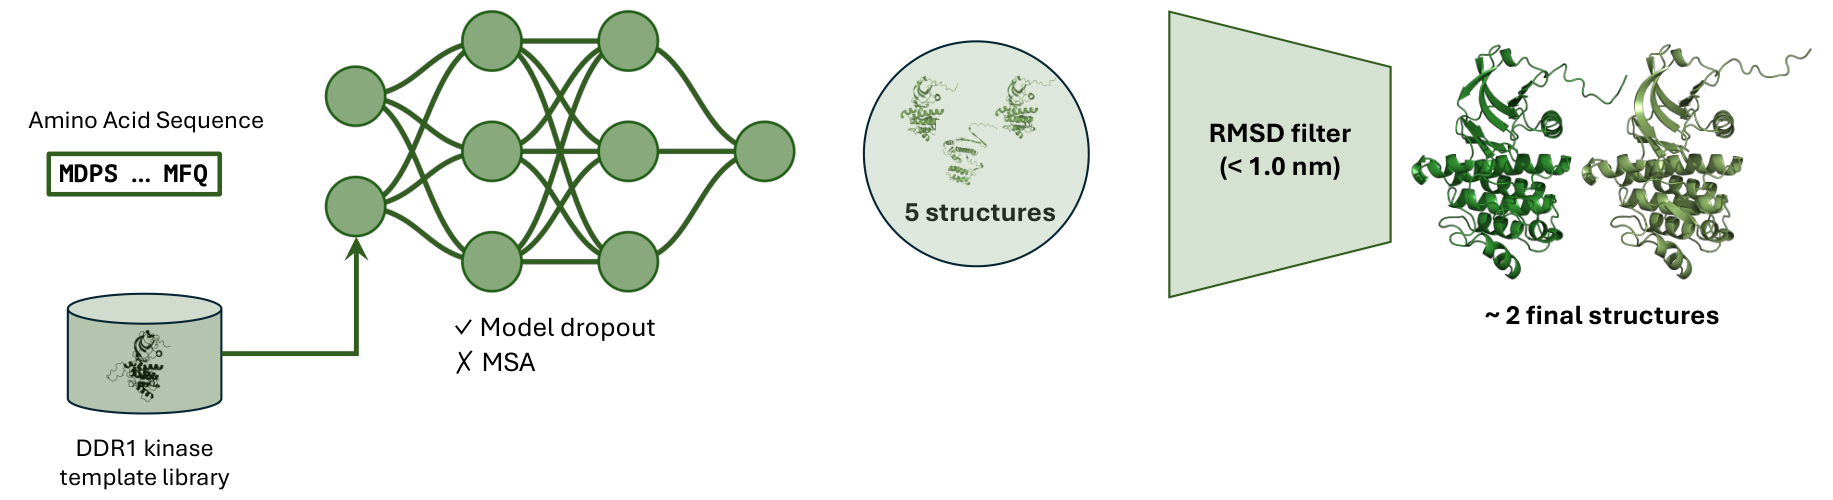

##Notes

*    We provide 15 DDR1 kinase template structures, of which users can choose to select either all the template structures or specific ones. (template_mode)
*    These templates denote possible conformations for type II inhibitors.
*    For details regarding the template structures or the Alphafold2RAVE protocol for kinase with type II inhibitors, see [X. Gu, A. Aranganathan et al. eLife 2024](https://doi.org/10.7554/eLife.99702.1) and [AF2RAVE-GLIDE git repo](https://github.com/tiwarylab/AF2RAVE_Glide-kinase).
*    For additional details on Alphafold2RAVE, see [Vani, Aranganathan et al. JCTC. 2023](https://doi.org/10.1021/acs.jctc.3c00290) and [Vani, Aranganathan et al. JCIM. 2024](https://doi.org/10.1021/acs.jcim.3c01436).


In [ ]:
import os
os.chdir("/content/")
try:
  !rm -r AF2RAVE_Glide-kinase
except:
  pass
!git clone https://github.com/tiwarylab/AF2RAVE_Glide-kinase


rm: cannot remove 'AF2RAVE_Glide-kinase': No such file or directory
Cloning into 'AF2RAVE_Glide-kinase'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 101 (delta 48), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (101/101), 4.80 MiB | 6.97 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [ ]:
#@title Install dependencies
%%time
from google.colab import files
import os
import re
import hashlib
import random

!mkdir colabfold
%cd /content/colabfold

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"


import os
USE_AMBER = False
USE_TEMPLATES = True
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install mdtraj")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("pip install --upgrade dm-haiku")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer mdtraj")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

import numpy as np
import mdtraj as md

/content/colabfold
installing colabfold...
installing conda...
installing hhsuite...
CPU times: user 609 ms, sys: 136 ms, total: 746 ms
Wall time: 1min 50s


In [ ]:
#@title Input protein sequence(s) and MSA parameters
%cd /content/colabfold

query_sequence = 'MDPSSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVSAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQ' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer

template_mode = "prescribed-all" #@param ["none", "custom", "prescribed-all", "prescribed-ifda","prescribed-ifdb","prescribed-ifdc","prescribed-ifdd","prescribed-ifde","prescribed-ifdf","prescribed-ifdg","prescribed-ifdh","prescribed-ifdi","prescribed-ifdj","prescribed-ifdk","prescribed-ifdl","prescribed-ifdm","prescribed-ifdn","prescribed-ifdo"]

msa_mode = "no_msa" #@param ["no_msa", "mmseqs2", "custom"]
#@markdown  - Choose the type of MSA input `[no msa, mmseqs2, custom]`

#@markdown  - For template AF2 `no_msa` is prescribed

max_msa = "8:16" #@param ["16:32","8:16","4:8", "2:4","1:2"]
#@markdown  - Choose `max_msa_cluster:max_extra_msa` to reduce the length of MSA used in initialization of AF2 (prescribed 16:32 and/or 8:16)

#@markdown  - For `msa_mode = no_msa` the `max_msa` values are not used


# Initializations and creating working dir
jobname = 'test'
pair_mode = "unpaired_paired"
query_sequence = "".join(query_sequence.split())
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
model_type = "auto"
num_recycles = 1
recycle_early_stop_tolerance = None
relax_max_iterations = 200
pairing_strategy = "greedy"
use_dropout = True
save_all = True
save_recycles = False
save_to_google_drive = False
dpi = 200
def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]
jobname = add_hash(basejobname, query_sequence)
# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"
os.makedirs(jobname, exist_ok=True)

#save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

# MSA decision
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')
else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

if msa_mode=='no_msa':
  msa_mode='single_sequence'
  max_msa = "8:16"           #For no MSA this parameter cannot go below 8:16

print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



/content/colabfold
sequence MDPSSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVSAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQ
length 274


In [ ]:
#@title Prepare templates (upload if `template_mode == custom`)

#@markdown For custom templates make sure the pdb files are named with 4 characters. eg. `ifda.pdb`
custom_template_paths=[]
%cd /content/colabfold
# for iterating over all the prescribed templates
if template_mode == "prescribed-all":
  custom_template_path = os.path.join(jobname,f"template")
  use_templates = True
  try:
    os.rmdir(custom_template_path)
  except:
    os.makedirs(custom_template_path)
  ascii_offset=97
  for i in range(15):
    prefix_template=f"ifd{chr(ascii_offset+i)}"
    custom_template_path_i=os.path.join(custom_template_path,prefix_template)
    os.makedirs(custom_template_path_i)
    custom_template_paths.append(custom_template_path_i)
    os.system(f"cp /content/AF2RAVE_Glide-kinase/DDR1_classical_DFG-out_templates/{prefix_template}.pdb {custom_template_path_i}/{prefix_template}.pdb")

# for custom templates
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  custom_template_paths.append(custom_template_path)
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))

# for no templates
elif template_mode=='none':
  custom_template_path = None
  custom_template_paths.append(custom_template_path)
  use_templates = False

# for specific template files - comes under prescribed-ifda or prescribed-ifdb ...
else:
  custom_template_path = os.path.join(jobname,f"template")
  use_templates = True
  try:
    os.rmdir(custom_template_path)
  except:
    os.makedirs(custom_template_path)

  prefix_template=template_mode.split('-')[-1]
  custom_template_paths.append(custom_template_path)
  os.system(f"cp /content/AF2RAVE_Glide-kinase/DDR1_classical_DFG-out_templates/{prefix_template}.pdb {custom_template_path}/{prefix_template}.pdb")




/content/colabfold


In [ ]:
#@title Run Prediction
%cd /content/colabfold

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
  setup_logging(Path(log_filename))
  logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True
num_relax=0
download_alphafold_params(model_type, Path("."))

result_dirs=[]
pdb_filenames=[]
json_filenames=[]
for i,template_path in enumerate(custom_template_paths):

  if template_path is not None:
    result_dir = f"{jobname}_template_{i}"
    try:
      os.rmdir(result_dir)
    except:
      os.makedirs(result_dir,exist_ok=True)
  else:
    result_dir = jobname

  result_dirs.append(result_dir)
  results = run(
      queries=queries,
      result_dir=result_dir,
      use_templates=use_templates,
      custom_template_path=template_path,
      num_relax=num_relax,
      msa_mode=msa_mode,
      model_type=model_type,
      num_models=5,
      num_recycles=num_recycles,
      relax_max_iterations=relax_max_iterations,
      recycle_early_stop_tolerance=recycle_early_stop_tolerance,
      num_seeds=1,
      use_dropout=use_dropout,
      model_order=[1,2,3,4,5],
      is_complex=is_complex,
      data_dir=Path("."),
      keep_existing_results=False,
      rank_by="auto",
      pair_mode=pair_mode,
      pairing_strategy=pairing_strategy,
      stop_at_score=float(100),
      prediction_callback=None,
      dpi=dpi,
      zip_results=False,
      save_all=save_all,
      max_msa=max_msa,
      use_cluster_profile=use_cluster_profile,
      input_features_callback=None,
      save_recycles=save_recycles,
      user_agent="colabfold/google-colab-main",
  )
  jobname_prefix = ".custom" if msa_mode == "custom" else ""
  pdb_rank1=md.load(f"{result_dir}/{jobname}{jobname_prefix}_unrelaxed_{results['rank'][0][0]}.pdb")
  for ranks in range(5):
    tag = results["rank"][0][ranks]
    pdb_file=md.load(f"{result_dir}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb")
    if md.rmsd(pdb_file,pdb_rank1)<1.0:
      os.system(f"cp {result_dir}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb {result_dir}/pred_template{i}_{ranks+1}.pdb")
      os.system(f"cp {result_dir}/{jobname}{jobname_prefix}_scores_{tag}.json {result_dir}/pred_template{i}_{ranks+1}.json")
      pdb_filenames.append(f"{result_dir}/pred_template{i}_{ranks+1}.pdb")
      json_filenames.append(f"{result_dir}/pred_template{i}_{ranks+1}.json")



/content/colabfold


2024-07-03 04:51:58,741 Running on GPU
2024-07-03 04:51:59,206 Found 5 citations for tools or databases
2024-07-03 04:51:59,449 Query 1/1: test_9b7e4 (length 274)
2024-07-03 04:52:00,397 Sequence 0 found templates: ['ifda_A', 'ifda_A']
2024-07-03 04:53:14,292 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=85.9 pTM=0.864
2024-07-03 04:53:21,810 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=85.7 pTM=0.861 tol=1.26
2024-07-03 04:53:21,812 alphafold2_ptm_model_1_seed_000 took 68.0s (1 recycles)
2024-07-03 04:53:29,632 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=87.2 pTM=0.873
2024-07-03 04:53:37,270 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=86.8 pTM=0.867 tol=0.708
2024-07-03 04:53:37,273 alphafold2_ptm_model_2_seed_000 took 15.2s (1 recycles)
2024-07-03 04:53:58,019 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=28.3 pTM=0.185
2024-07-03 04:54:04,984 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=28.5 pTM=0.206 tol=6.2
2024-07-03 04:54:04,986 alphafold2_ptm_model_3_seed_000

In [ ]:
#@title Structure generation results and file managing
print("\n\n~~~~~~~~~Details about the structure generation results~~~~~~~~~~~")
print(f"\nTotal number of template sets: {len(custom_template_paths)}")
print(f"\nTotal number of structures generated: {len(pdb_filenames)}")

os.chdir('/content/colabfold/')

if not os.path.isdir('/content/structures'):
  os.mkdir('/content/structures')
else:
  print('\n!!! /content/structures already exists and moved to /content/backup !!!\n')
  try:
    os.system('rm -r /content/backup')
  except:
    pass
  os.system('mv /content/structures /content/backup')
  os.mkdir('/content/structures')

for i in range(len(pdb_filenames)):
  os.system(f"cp {pdb_filenames[i]} /content/structures/{pdb_filenames[i].split('/')[-1]}")
  os.system(f"cp {json_filenames[i]} /content/structures/{json_filenames[i].split('/')[-1]}")
  #os.system(f"rm -r {json_filenames[i].split('/')[0]}")
os.chdir('/content/')
os.system('zip -r structures.zip structures')

print("All generated structures (following) are present in 'structures' directory and 'structures.zip' file\n")
for pdb_filename in pdb_filenames: print(f"{pdb_filename.split('/')[-1]}")



~~~~~~~~~Details about the structure generation results~~~~~~~~~~~

Total number of template sets: 15

Total number of structures generated: 30
All generated structures (following) are present in 'structures' directory and 'structures.zip' file

pred_template0_1.pdb
pred_template0_2.pdb
pred_template1_1.pdb
pred_template1_2.pdb
pred_template2_1.pdb
pred_template2_2.pdb
pred_template3_1.pdb
pred_template3_2.pdb
pred_template4_1.pdb
pred_template4_2.pdb
pred_template5_1.pdb
pred_template5_2.pdb
pred_template6_1.pdb
pred_template6_2.pdb
pred_template7_1.pdb
pred_template7_2.pdb
pred_template8_1.pdb
pred_template8_2.pdb
pred_template9_1.pdb
pred_template9_2.pdb
pred_template10_1.pdb
pred_template10_2.pdb
pred_template11_1.pdb
pred_template11_2.pdb
pred_template12_1.pdb
pred_template12_2.pdb
pred_template13_1.pdb
pred_template13_2.pdb
pred_template14_1.pdb
pred_template14_2.pdb


In [ ]:
#@title View all generated structures
import py3Dmol
from ipywidgets import interact,fixed,IntSlider
import ipywidgets

def MolTo3DView(mol, size=(600, 600), style="cartoon", resids=None,surface=False, opacity=0.5):

    assert style in ('line', 'stick', 'sphere', 'cartoon')
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(open(mol,'r').read(),'pdb')
    viewer.setStyle({style:{}})
    viewer.setStyle({'cartoon': {'color':'silver'}})
    if resids is not None:
      for resid in resids:
        viewer.addStyle({'resi':resid},{'stick':{'color':"red",'radius':0.3}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

show_residue_specific_sidechain=True #@param {type:"boolean"}
#@markdown Specify the residue numbers if `show_residue_specific_sidechain == True`

#@markdown For multiple residues use `,` to seperate. eg. `157,158,159`
residue_ids= "157,158,159" #@param {type:"string"}

if show_residue_specific_sidechain:
  resids=[int(residue_string) for residue_string in residue_ids.split(',')]
else:
  resids=None

def conf_viewer(idx):
  mol = f"/content/structures/{pdb_filenames[idx].split('/')[-1]}"
  return MolTo3DView(mol,resids=resids).show()

interact(conf_viewer, idx=ipywidgets.IntSlider(min=0,max=len(pdb_filenames)-1, step=1))

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<function __main__.conf_viewer(idx)>